In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
#http://fnl.es/a-quick-reference-for-working-with-tensorflow.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pyvirtualdisplay import Display

import tensorflow.compat.v1 as tf
from collections import deque
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input , BatchNormalization, Concatenate, LayerNormalization, LSTM,Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
import random
import tqdm
import pandas as pd

tf.disable_eager_execution()
import math
import time


In [3]:
tf.reset_default_graph()
epsilon = 1
np.random.seed(0)
tf.set_random_seed(0)
random.seed(0)

In [4]:
class Agent:
    def __init__(self, name, state_shape, env, sess, reuse=False):
        with tf.name_scope(name):
            self.name = name
            self.reuse = reuse

            inputs = Input(shape=state_shape)
            x = Dense(256, activation='relu', name ="inp1")(inputs)
            rnn_in = Reshape((1 ,x.shape[1]), input_shape=x.shape)(x)
            x = LSTM(128, return_sequences=False, name ="lstm_enc_1")(rnn_in)

            mu = Dense(units=env.action_space.shape[0], activation=tf.nn.tanh,name='actor_mu' )(x)
            sigma = Dense(units=env.action_space.shape[0], activation=tf.nn.softplus, name='actor_sigma' )(x)
            mu, sigma = tf.squeeze(mu*2), tf.squeeze(sigma +  1e-5)
            normal_dist = tfp.distributions.Normal(mu, sigma)
            action = tf.clip_by_value(normal_dist.sample(1), env.action_space.low[0], env.action_space.high[0])


            state_value = Dense(1, activation='linear', name ="v")(x)
            self.network = Model(inputs=inputs, outputs=[action, state_value,mu, sigma])

            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.agent_outputs = self.symbolic_step(self.state_t)

    def symbolic_step(self, state_t):
        act,s,m, sig = self.network(state_t)
        return act, s[:,0], m, sig

    def sample_actions(self, state_t,epsilon):
        act,_,_,_= sess.run(self.agent_outputs, {self.state_t: state_t})
        return act


In [5]:
class PendulumA3C:
    def __init__(self, sess,env, agent, lstm,gae):
        self.sess =sess

        self.filepath = "D:\\Artificial_Intelligence\\RL\\InvertedPendulum\\data.txt"
        self.batch_size =10
        self.memory = deque(maxlen= 500)
        self.gae_size = 20
        self.Training= 2000000#400000
        self.learning_rate= 0.00001#0.0002
        self.entropy_factor = 0.001

        self.rewards_history = []
        self.entropy_history = []
        self.actor_history =[]
        self.critic_history =[]
        self.advantage_history = []
        self.target_history =[]
        self.v_history =[]
        self.actionList =[]

        self.reward_step =0

        self.is_gae = gae
        self.isConvLSTM = lstm 
        self.env = env
        self.obs_shape = self.env.observation_space.shape
        self.n_actions = self.env.action_space.shape[0]

        print("Observation shape:", self.obs_shape)
        print("Num actions:", self.n_actions)

        self.agent = agent
        self.states_ph = tf.placeholder('float32', [None,] + list(self.obs_shape))    
        self.next_states_ph = tf.placeholder('float32', [None,] + list(self.obs_shape))
        self.actions_ph = tf.placeholder('float32', (None,))
        self.rewards_ph = tf.placeholder('float32', (None,))
        self.is_done_ph = tf.placeholder('float32', (None,))
        self.game_reward = tf.placeholder('float32', [None,])

        self.act, self.state_values,self.mu, self.sigma = self.agent.symbolic_step(self.states_ph)
        self.next_act, self.next_state_values, self.next_mu, self.next_sigma = self.agent.symbolic_step(self.next_states_ph)

        self.gamma = 0.99

        self.next_state_values = self.next_state_values * (1 - self.is_done_ph)
        self.advantage = self.rewards_ph + self.gamma*self.next_state_values - self.state_values
        self.target_state_values = self.rewards_ph+self.gamma*self.next_state_values

        self.normal_dist = tfp.distributions.Normal(self.mu, self.sigma)
        self.entropy = self.normal_dist.entropy() 

        self.actor_loss = -tf.reduce_mean((self.normal_dist.log_prob(self.actions_ph) * tf.stop_gradient(self.advantage)) + self.entropy_factor*self.entropy)
        self.critic_loss = tf.reduce_mean((self.state_values - tf.stop_gradient(self.target_state_values))**2, axis=0)
        self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.actor_loss + self.critic_loss)


    def evaluate(self, n_games=1):
        game_rewards = []
        for _ in range(n_games):
            state = self.env.reset()

            total_reward = 0
            while True:
                action = self.agent.sample_actions([state],0)
                state, reward, done, info = self.env.step(action)
                total_reward += reward
                if done:
                    break
            game_rewards.append(total_reward)

        self.rewards_history.append(np.mean(game_rewards))
        self.reward_step +=1

        return game_rewards


    def train(self,batch_states,batch_actions,batch_next_states,batch_rewards,batch_done,step):
        batch_actions = batch_actions.reshape(self.batch_size,)

        feed_dict = {
                self.states_ph: batch_states,
                self.actions_ph: batch_actions,
                self.next_states_ph: batch_next_states,
                self.rewards_ph: batch_rewards,
                self.is_done_ph: batch_done,
            }

        _, ent_t,act,crit,adv,targ,v = sess.run([self.train_step, self.entropy,self.actor_loss ,self.critic_loss,self.advantage,
                                                 self.target_state_values,self.state_values], feed_dict)


        self.entropy_history.append(np.mean(ent_t))
        self.actor_history.append(np.mean(act))
        self.critic_history.append(np.mean(crit))
        self.advantage_history.append(np.mean(adv))
        self.target_history.append(np.mean(targ))
        self.v_history.append(np.mean(v))
        for a in batch_actions:
            self.actionList.append(a)


    def ewma(self,x, span=100):
        return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

    def plots(self):
        ipythondisplay.clear_output(wait=True)
        plt.figure(figsize=[35,13])
        plt.subplot(2,4,1)
        plt.plot(self.rewards_history, label='reward')
        plt.plot(self.ewma(np.array(self.rewards_history), span=10), marker='.', label='rewards ewma@10')
        plt.title("Session rewards"); plt.grid(); plt.legend()

        plt.subplot(2,4,2)
        plt.plot(self.actor_history, label='Actor Loss')
        plt.plot(self.ewma(np.array(self.actor_history), span=10), marker='.', label='Actor Loss ewma@10')
        plt.title("Policy Function"); plt.grid(); plt.legend()  

        plt.subplot(2,4,3)
        plt.plot(self.entropy_history, label='Entropy')
        plt.plot(self.ewma(np.array(self.entropy_history), span=10), marker='.', label='Entropy ewma@10')
        plt.title("Policy Function"); plt.grid(); plt.legend()      

        plt.subplot(2,4,4)
        plt.plot(self.target_history, label='Target ')
        plt.plot(self.v_history, label='V')
        plt.title("Target/V"); plt.grid(); plt.legend()

        plt.subplot(2,4,5)
        plt.plot(self.advantage_history, label='Advantage')
        plt.title("Advantage"); plt.grid(); plt.legend()  

        plt.subplot(2,4,6)
        plt.plot(self.critic_history, label='Critic Loss')
        plt.plot(self.ewma(np.array(self.critic_history), span=10), marker='.', label='Critic Loss ewma@10')
        plt.title("Value function"); plt.grid(); plt.legend()   

        plt.subplot(2,4,7)
        plt.plot(self.actionList, label='Actions')
        plt.title("Actions"); plt.grid(); plt.legend()  

        plt.show()



In [6]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        self.envs = [gym.make("Pendulum-v0") for _ in range(n_envs)]
    
    def reset(self):
        return np.array([env.reset() for env in self.envs])
  
    def step(self, actions):
        results = [env.step([a]) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))

        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()

        return new_obs, rewards, done, infos


In [7]:
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(graph= tf.get_default_graph(), config =config)
RESET = 1
is_gae = False
isConvLSTM = True 


In [8]:
env = gym.make("Pendulum-v0")
agent = Agent("agent", env.observation_space.shape, env, sess,isConvLSTM)
pendulumA3C = PendulumA3C(sess,env,agent, isConvLSTM,is_gae)



Observation shape: (3,)
Num actions: 1


In [9]:

if (RESET == 1):
    # ************ RESET everything **************************
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    f=open(pendulumA3C.filepath, "w")
    f.write("")
    f.close()
else:
    # ************ LOAD everything **************************
    epsilon = 0.0001
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('D:\\Artificial_Intelligence\\RL\\InvertedPendulum\\'))
    pendulumA3C.plots()

# Validate
rewards = pendulumA3C.evaluate(n_games=3)
print(rewards)

env_batch = EnvBatch(10)
batch_states = env_batch.reset()
batch_actions = pendulumA3C.agent.sample_actions(batch_states,0)
batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions[0])

print("State shape:", batch_states.shape)
print("Actions:", batch_actions)
print("Rewards:", batch_rewards)
print("Done:", batch_done)

#Initialize
env_batch = EnvBatch(10)
batch_states = env_batch.reset()

[-1306.2044293406764, -1611.173211698024, -1260.8882438065332]
State shape: (10, 3)
Actions: [[-0.60749954 -0.48292458  0.66357505 -0.45459768 -0.6454407  -0.5278681
  -1.1867193   0.40316826 -0.38207757 -0.35361913]]
Rewards: [-1.67298858 -0.13366845 -7.4496193  -1.04447553 -3.36321404 -5.62673241
 -0.23911227 -0.68000903 -0.11148539 -6.30404888]
Done: [False False False False False False False False False False]


 95%|█████████████████████████████████████████████████████████████████▌   | 1899967/2000000 [1:14:45<03:28, 480.60it/s]

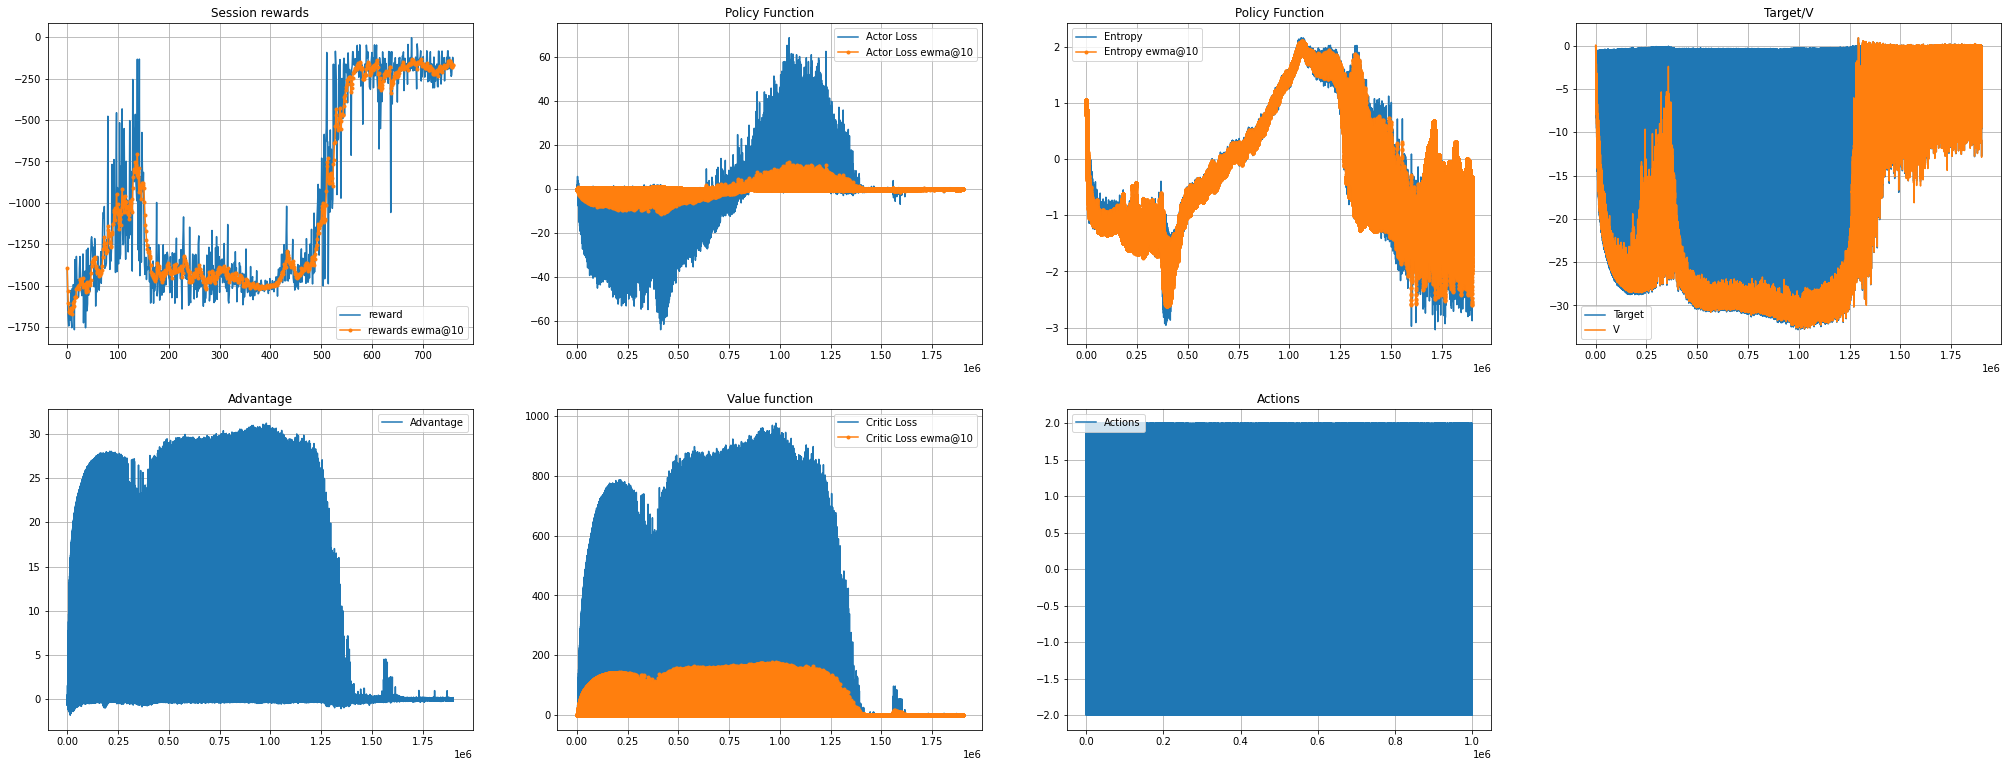

100%|█████████████████████████████████████████████████████████████████████| 2000000/2000000 [1:18:39<00:00, 423.79it/s]


In [10]:
epsilon = 1
f=open(pendulumA3C.filepath, "w")
with tqdm.trange(len(pendulumA3C.entropy_history), pendulumA3C.Training) as t:
    for i in t:
        batch_actions = pendulumA3C.agent.sample_actions(batch_states,epsilon)
        batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions[0])

        # Reward scaling
        batch_rewards = batch_rewards /16.2736044
        pendulumA3C.train(batch_states,batch_actions,batch_next_states,batch_rewards,batch_done,i)
        batch_states = batch_next_states

        if len(pendulumA3C.rewards_history)> 100 :
            if np.mean(pendulumA3C.rewards_history[-100:]) >= -150:
                print("Your agent reached the objetive")
                break
        
        if i % 100 == 0 and  epsilon > 0.01 :
                epsilon = epsilon*0.99
                
        if i % 500 == 0 and i >0:

                
            if i % 50000 == 0:
                saver.save(sess, "D:\\Artificial_Intelligence\\RL\\InvertedPendulum\\model.h5")

            if i % 2500 == 0:
                pendulumA3C.evaluate(n_games=3)
                
            if i %100000 ==0:
                f.close()
                f=open(pendulumA3C.filepath, "a+")
                pendulumA3C.plots()
                pendulumA3C.actionList = []


            f.write("%f %f %f %f %f %f %f\n" % (pendulumA3C.rewards_history[-1],pendulumA3C.actor_history[-1], pendulumA3C.entropy_history[-1], pendulumA3C.target_history[-1], pendulumA3C.v_history[-1], pendulumA3C.advantage_history[-1], pendulumA3C.critic_history[-1]))

f.close()

In [ ]:
def evaluate2(agent, env, n_games=1):
    game_rewards = []
    for _ in range(n_games):
        state = env.reset()
        total_reward = 0
        while True:
            action = agent.sample_actions([state],0)
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

env_monitor = gym.wrappers.Monitor(env, directory="D:\\Artificial_Intelligence\\RL\\InvertedPendulum\\videos", force=True)
final_rewards = evaluate2(pendulumA3C.agent, env_monitor, n_games=100)
env_monitor.close()

print("Final mean reward:", np.mean(final_rewards))